# 2021 Oceanography Camp for Girls Saildrone Lesson
Developed by Nancy Williams, Veronica Tamsitt, Nicola Guisewhite at University of South Florida College of Marine Science

## To Do List:
*

## Data Sources:
* 1-minute physical and ADCP data available from: https://data.saildrone.com/data/sets/antarctica-circumnavigation-2019
(login required, so cannot be accessed using an FTP. Will need to download ahead)
* hourly-ish CO2, pH data available from: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0221912
* Satellite Chlorophyll: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ocean-colour?tab=overview
* SSH: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview 
(login required for chla and SSH, download ahead of time. Can also be downloaded using motuclient, login also required https://github.com/clstoulouse/motu-client-python)

In [1]:
# Import the tools you need
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature

In [2]:
# Set the paths
output_dir = 'Output/'
data_dir = 'Data/'

In [3]:
# Go and download the hourly Saildrone CO2 data and put it in the `Data/` folder
os.chdir(data_dir) # Change the directory to the `Data/` folder
os.getcwd() # Check that you're now in the `Data/` folder
# Curl downloads the data files directly from the web and shows you the status while it works. 
# `!` at the beginning of the line tells you that this command is a unix shell command (not python code)
! curl -o 32DB20190119_ASV_Saildrone1020_Antarctic_Jan2019_Aug2019.csv https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0221912/32DB20190119_ASV_Saildrone1020_Antarctic_Jan2019_Aug2019.csv
os.chdir("..") # Use ".." to move back up one directory now that we've imported the MLD climatology data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  779k  100  779k    0     0   423k      0  0:00:01  0:00:01 --:--:--  423k


In [4]:
# Import the hourly Saildrone CO2 data file
Saildrone_CO2 = pd.read_csv(
    (data_dir + '32DB20190119_ASV_Saildrone1020_Antarctic_Jan2019_Aug2019.csv'),
    header=4,
    na_values=-999,
)
# Check that the Saildrone data was imported correctly
Saildrone_CO2

,Mooring Name,Latitude,Longitude,Date,Time,xCO2 SW (wet) (umol/mol),CO2 SW QF,H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),CO2 Air QF,...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,WSPD (m/s),WSPD QF
0,Saildrone1020_Antarctic,-47.1136,170.7967,01/19/2019,20:17,384.1,2,2.50,402.5,2,...,385.1,403.5,371.9,389.7,-17.8,373.3,391.1,-17.8,14.7,2
1,Saildrone1020_Antarctic,-47.1410,170.9156,01/19/2019,21:17,372.7,2,2.54,402.0,2,...,373.7,403.0,361.0,389.4,-28.4,362.3,390.8,-28.5,17.2,2
2,Saildrone1020_Antarctic,-47.1722,171.0097,01/19/2019,22:17,383.7,2,2.80,401.5,2,...,384.7,402.6,371.4,388.6,-17.3,372.8,390.1,-17.3,12.0,2
3,Saildrone1020_Antarctic,-47.2080,171.1025,01/19/2019,23:17,382.3,2,2.87,401.4,2,...,383.4,402.5,369.9,388.3,-18.4,371.2,389.7,-18.5,15.7,2
4,Saildrone1020_Antarctic,-47.2467,171.1973,01/20/2019,00:17,381.0,2,2.99,400.7,2,...,382.2,401.9,368.5,387.5,-19.1,369.8,388.9,-19.1,15.3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4822,Saildrone1020_Antarctic,-46.6145,167.8519,08/03/2019,00:17,381.6,2,2.57,407.1,2,...,382.6,408.1,369.3,393.9,-24.7,370.7,395.4,-24.8,NaN,5
4823,Saildrone1020_Antarctic,-46.6355,167.9759,08/03/2019,01:17,382.5,2,2.71,406.6,2,...,383.5,407.6,369.7,393.0,-23.3,371.1,394.5,-23.3,NaN,5
4824,Saildrone1020_Antarctic,-46.6482,168.1009,08/03/2019,02:17,381.6,2,2.32,407.3,2,...,382.5,408.3,368.2,393.0,-24.8,369.6,394.5,-24.9,NaN,5
4825,Saildrone1020_Antarctic,-46.6464,168.2423,08/03/2019,03:17,381.6,2,1.71,407.8,2,...,382.3,408.5,368.4,393.7,-25.3,369.8,395.2,-25.4,NaN,5


In [11]:
# Import the one-minute resolution Saildrone Physical data file
ds = xr.open_dataset(data_dir + 'saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc')
Saildrone_phys = ds.to_dataframe()
Saildrone_phys

,obs,trajectory,SOG,COG,HDG,HDG_WING,WING_ANGLE,UWND_MEAN,UWND_STDDEV,VWND_MEAN,...,O2_CONC_RBR_STDDEV,O2_SAT_RBR_MEAN,O2_SAT_RBR_STDDEV,TEMP_O2_RBR_MEAN,TEMP_O2_RBR_STDDEV,CHLOR_RBR_MEAN,CHLOR_RBR_STDDEV,latitude,longitude,time
0,0,1020.0,1.762,119.8,108.2,107.1,-1.1,13.7,1.57,-4.27,...,0.22,96.29,0.09,15.682,0.002,1.5053,0.0268,-46.683142,168.517056,2019-01-19 04:00:00
1,1,1020.0,1.361,118.8,104.8,103.7,-1.1,NaN,NaN,NaN,...,0.10,96.24,0.04,15.673,0.002,1.5336,0.1127,-46.683686,168.518438,2019-01-19 04:01:00
2,2,1020.0,2.423,119.4,122.4,122.3,0.0,NaN,NaN,NaN,...,0.11,96.15,0.04,15.684,0.003,1.4532,0.0275,-46.684218,168.519962,2019-01-19 04:02:00
3,3,1020.0,1.789,116.9,110.2,109.7,-0.5,NaN,NaN,NaN,...,0.19,95.99,0.08,15.690,0.003,1.4437,0.0430,-46.684675,168.521280,2019-01-19 04:03:00
4,4,1020.0,1.555,119.9,123.2,121.8,-1.4,NaN,NaN,NaN,...,0.14,95.99,0.06,15.690,0.002,1.3903,0.0465,-46.685165,168.522586,2019-01-19 04:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282266,282266,1020.0,4.029,342.0,335.1,107.3,130.2,NaN,NaN,NaN,...,0.07,96.13,0.03,9.888,0.005,77.0648,2.8832,-46.604157,168.361498,2019-08-03 04:26:00
282267,282267,1020.0,4.011,321.0,319.7,107.3,145.6,NaN,NaN,NaN,...,0.16,96.18,0.06,9.882,0.003,36.2703,3.0169,-46.602474,168.359770,2019-08-03 04:27:00
282268,282268,1020.0,3.432,312.1,312.3,107.3,152.2,NaN,NaN,NaN,...,0.17,96.19,0.06,9.886,0.001,99.6159,3.3730,-46.601005,168.357760,2019-08-03 04:28:00
282269,282269,1020.0,3.646,318.2,317.3,107.3,147.8,NaN,NaN,NaN,...,0.21,96.11,0.07,9.876,0.006,69.3397,1.7296,-46.599642,168.355635,2019-08-03 04:29:00


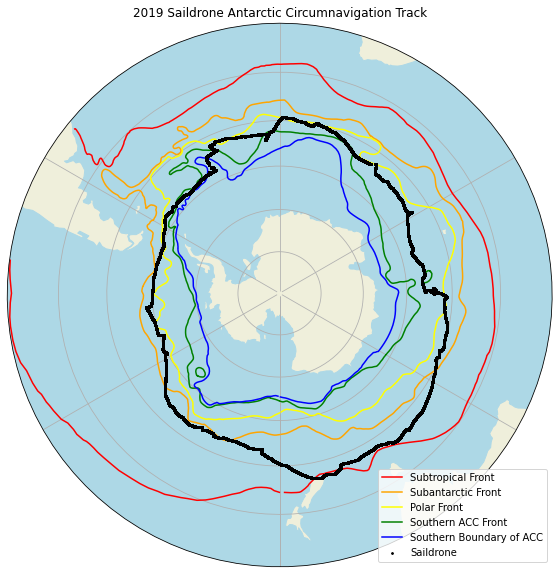

In [26]:
# Plot the Saildrone track on a map

# Import the Southern Ocean fronts
stf = pd.read_csv('Data/fronts/stf.txt', header=None, sep='\s+', na_values='%', names=['lon','lat'])
saf = pd.read_csv('Data/fronts/saf.txt', header=None, sep='\s+', na_values='%', names=['lon','lat'])
pf = pd.read_csv('Data/fronts/pf.txt', header=None, sep='\s+', na_values='%', names=['lon','lat'])
saccf = pd.read_csv('Data/fronts/saccf.txt', header=None, sep='\s+', na_values='%', names=['lon','lat'])
sbdy = pd.read_csv('Data/fronts/sbdy.txt', header=None, sep='\s+', na_values='%', names=['lon','lat'])

# Make the "bones" of the figure
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Plot the ACC fronts in various colors
ax.set_boundary(circle, transform=ax.transAxes)
plt.plot(stf['lon'], stf['lat'], color='Red', transform=ccrs.PlateCarree(), label = 'Subtropical Front')
plt.plot(saf['lon'], saf['lat'], color='Orange', transform=ccrs.PlateCarree(), label = 'Subantarctic Front')
plt.plot(pf['lon'], pf['lat'], color='Yellow', transform=ccrs.PlateCarree(), label = 'Polar Front')
plt.plot(saccf['lon'], saccf['lat'], color='Green', transform=ccrs.PlateCarree(), label = 'Southern ACC Front')
plt.plot(sbdy['lon'], sbdy['lat'], color='Blue', transform=ccrs.PlateCarree(), label = 'Southern Boundary of ACC')

# Plot the Saildrone in black dots
plt.scatter(Saildrone_phys.longitude, Saildrone_phys.latitude,
           transform=ccrs.PlateCarree(), c='black', s=3, label='Saildrone', zorder=1000)

# Turn on the legend
plt.legend()

# Save the figure in the output folder
plt.title('2019 Saildrone Antarctic Circumnavigation Track')
plt.savefig(output_dir + 'SaildroneMap' + '.jpg') # Changing the suffix will change the format
plt.show()